In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset

In [48]:
#functions:

def i_n(series):
    i = 0
    dftest = adfuller(np.diff(series,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(series,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [49]:
p1_gen = pd.read_csv('../../data/p1_gen_dtindex.csv', index_col=0, parse_dates=True)
p1_gen.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [50]:
# the index has been preserved as a date time object, along with time stamps.

print(type(p1_gen.index))
p1_gen.index

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               ...
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=68778, freq=None)

In [51]:
# making copy of og df

pred_gen_og = p1_gen.copy()

---

# SARIMAX FSM

5 days starting 6/13

- 4 days train
- 1 day test
- 2 days forecasted forward

In [52]:
# Seeing the month of june here.

pred_gen_jun = pred_gen_og[(pred_gen_og.index.month == 6)]
pred_gen_jun = pred_gen_jun.groupby('DATE_TIME').sum()
pred_gen_jun

# per the plot below, there is a drop off in the beginning of the month.

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,
2020-06-01 00:00:00,90970022,0.0,0.0,5407.250000,153519480.0
2020-06-01 00:15:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 00:30:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 00:45:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 01:00:00,90970022,0.0,0.0,0.000000,153519480.0
...,...,...,...,...,...
2020-06-17 22:45:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:00:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:15:00,90970022,0.0,0.0,129571.000000,156142755.0


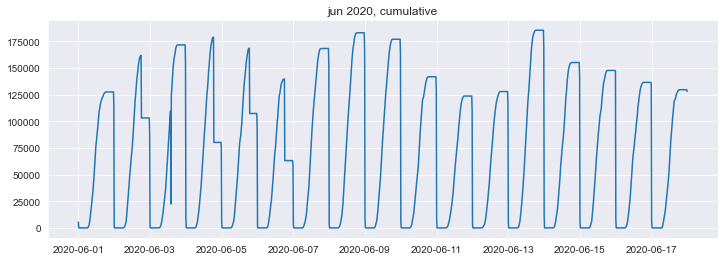

In [53]:
plt.subplots(figsize = (12,4))
plt.plot(pred_gen_jun.DAILY_YIELD)
plt.title('jun 2020, cumulative');

In [85]:
# pred_gen: data from 6/13 and on

pred_gen = pred_gen_jun[pred_gen_jun.index >= '2020-06-13 00:00:00'][['DAILY_YIELD']]
# Note: df['col'] returns a series. And, you can use the to_frame method to convert that series into a dataframe. Or use the double brackets, [[]].

pred_gen

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


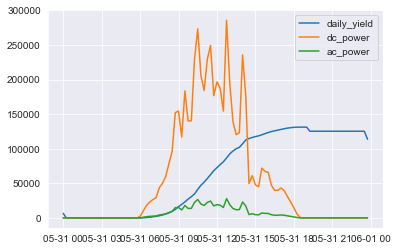

In [86]:
# trying to see what the daily_yield at 00:00:00 time stamp means. There is no dc output then...

pred_gen_5_31 = pred_gen_og[(pred_gen_og.index.month == 5) 
                            & (pred_gen_og.index.day == 31)].groupby('DATE_TIME').sum()
plt.plot(pred_gen_5_31.DAILY_YIELD, label='daily_yield')
plt.plot(pred_gen_5_31.DC_POWER, label='dc_power')
plt.plot(pred_gen_5_31.AC_POWER, label='ac_power')
plt.legend()
plt.show()

# Don't know what is happenig here..
# Going to leave this for now, and continue with my models

In [87]:
pred_gen.shape

(478, 1)

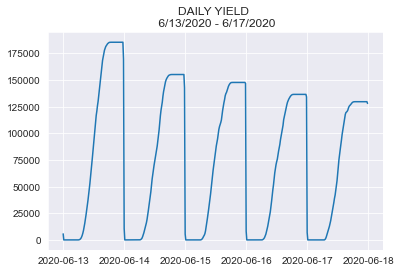

In [88]:
plt.plot(pred_gen)
plt.title('DAILY YIELD \n 6/13/2020 - 6/17/2020');

In [89]:
# checking number of records per day (for seasonality (m) within ARIMA):

print(len(pred_gen[pred_gen.index.day == 13]))
print(len(pred_gen[pred_gen.index.day == 14]))
print(len(pred_gen[pred_gen.index.day == 15]))
print(len(pred_gen[pred_gen.index.day == 16]))
print(len(pred_gen[pred_gen.index.day == 17]))

96
96
96
96
94


## Dickey-Fuller Test

In [90]:
result = adfuller(pred_gen['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.6038808334484527
p-value : 0.09219782793309467
#Lags Used : 1
Number of Observations Used : 476
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [118]:
result

(-2.6038808334484527,
 0.09219782793309467,
 1,
 476,
 {'1%': -3.444162847239118,
  '5%': -2.8676311169658177,
  '10%': -2.5700143303792107},
 10020.044319459144)

## Test-Train Split

(382, 1) (96, 1)


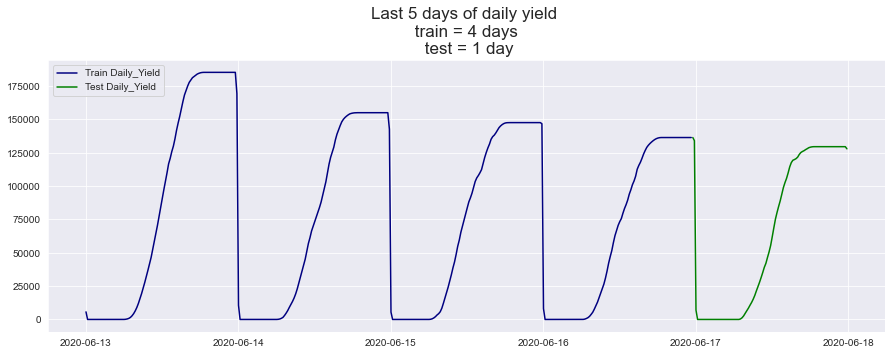

In [106]:
df = pred_gen
eotri_percent = .8

eotri = round(df.shape[0] * eotri_percent)

train = df[:eotri]
test = df[eotri:]

print(train.shape, test.shape)

fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train, label='Train Daily_Yield', color='navy')
ax.plot(test, label='Test Daily_Yield', color='green')
ax.set_title('Last 5 days of daily yield \n train = 4 days \n test = 1 day', fontsize=17)
ax.legend(loc='upper left')
plt.show()

In [92]:
train.head()

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000


In [93]:
test.head()

,DAILY_YIELD
DATE_TIME,
2020-06-16 23:30:00,136429.000000
2020-06-16 23:45:00,134079.375000
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000


## auto_arima

i =  1 



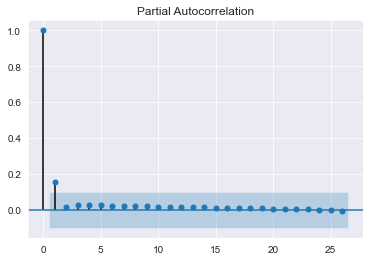

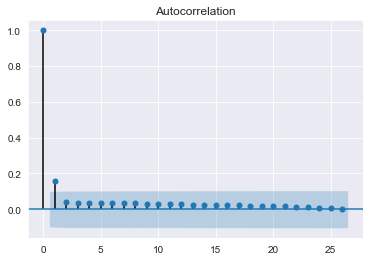

In [120]:
# Number of differencing needed for stationarity:

i = i_n(train.DAILY_YIELD)
print('i = ', i, '\n')

plot_pacf(np.diff(train.DAILY_YIELD,i)); #ar

plot_acf(np.diff(train.DAILY_YIELD,i)); #ma

#### Per above, the best ar,i,ma values = 1,1,1

let's check with auto_arima below:

In [127]:
arima_model = auto_arima(train,
                         start_p=0,d=i,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=5067.919, Time=2.16 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=4789.601, Time=40.43 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(0,1,1)[96]             : AIC=4862.931, Time=13.61 sec
 ARIMA(1,1,0)(0,1,0)[96]             : AIC=5053.868, Time=2.15 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96]             : AIC=4778.731, Time=64.79 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(0,1,1)[96]             : AIC=4861.848, Time=13.43 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(1,1,1)[96]             : AIC=4902.160, Time=21.76 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,0)(1,1,1)[96]             : AIC=4864.875, Time=37.31 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(1,1,1)[96]             : AIC=4865.791, Time=40.28 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(1,1,1)[96]             : AIC=4864.721, Time=64.37 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,1)(1,1,1)[96]             : AIC=4867.256, Time=48.07 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96] intercept   : AIC=4779.901, Time=95.62 sec

Best model:  ARIMA(1,1,0)(1,1,1)[96]          
Total fit time: 444.290 seconds


## Predicting

In [149]:
prediction = arima_model.predict(n_periods=96, return_conf_int=True)
prediction

(array([136431.01577139, 133115.00253376,  -5393.55561408, -13084.3058679 ,
        -13084.16942113, -13084.16524444, -13084.16511659, -13084.16511268,
        -13084.16511256, -13084.16511255, -13084.16511255, -13084.16511255,
        -13084.16511255, -13084.16511255, -13084.16511255, -13084.16511255,
        -13084.16511255, -13084.16511255, -13084.16511255, -13084.16511255,
        -13084.16511255, -13084.16511255, -13084.16511256, -13084.16511277,
        -13084.16511951, -13084.16533997, -13082.011127  , -13029.7375261 ,
        -12777.87472952, -12288.5431987 , -11592.12662303, -10548.21373107,
         -9168.33868685,  -7577.90097469,  -5195.63285383,  -2365.16368973,
           493.24391388,   3896.33967458,   7157.05030265,  10731.77300959,
         14641.79265031,  19250.02806501,  24366.60228858,  30183.39143947,
         35328.30751867,  39924.28052993,  45861.50058212,  50988.04114663,
         54989.52683727,  58963.11025552,  62135.59377823,  64833.51025712,
         686

In [187]:
# I need to convert prediction into a dataframe with cols: pred_daily_yld, conf_lower, conf_upper

prediction_yhat_df = pd.DataFrame(prediction[0],index=test.index,columns=['pred_daily_yld'])
prediction_yhat_df

prediction_conf_df = pd.DataFrame(prediction[1], 
                                  index=test.index, 
                                  columns=['conf_lower', 'conf_upper'])

# join the two 
prediction_df = prediction_yhat_df.join(prediction_conf_df)

# zero out neg values in pred_daily_yld col only
# prediction_df['pred_daily_yld'][prediction_df.pred_daily_yld < 0] = 0
prediction_df[prediction_df < 0] = 0
prediction_df

,pred_daily_yld,conf_lower,conf_upper
DATE_TIME,,,
2020-06-16 23:30:00,136431.015771,134413.930005,138448.101538
2020-06-16 23:45:00,133115.002534,130171.047899,136058.957169
2020-06-17 00:00:00,0.000000,0.000000,0.000000
2020-06-17 00:15:00,0.000000,0.000000,0.000000
2020-06-17 00:30:00,0.000000,0.000000,0.000000
...,...,...,...
2020-06-17 22:45:00,126034.361288,105399.111072,146669.611505
2020-06-17 23:00:00,126034.361289,105287.107455,146781.615123
2020-06-17 23:15:00,126034.361305,105175.705264,146893.017345


In [188]:
prediction_df['actual_daily_yld'] = test.DAILY_YIELD
prediction_df.head()

,pred_daily_yld,conf_lower,conf_upper,actual_daily_yld
DATE_TIME,,,,
2020-06-16 23:30:00,136431.015771,134413.930005,138448.101538,136429.000000
2020-06-16 23:45:00,133115.002534,130171.047899,136058.957169,134079.375000
2020-06-17 00:00:00,0.000000,0.000000,0.000000,6955.232143
2020-06-17 00:15:00,0.000000,0.000000,0.000000,0.000000
2020-06-17 00:30:00,0.000000,0.000000,0.000000,0.000000


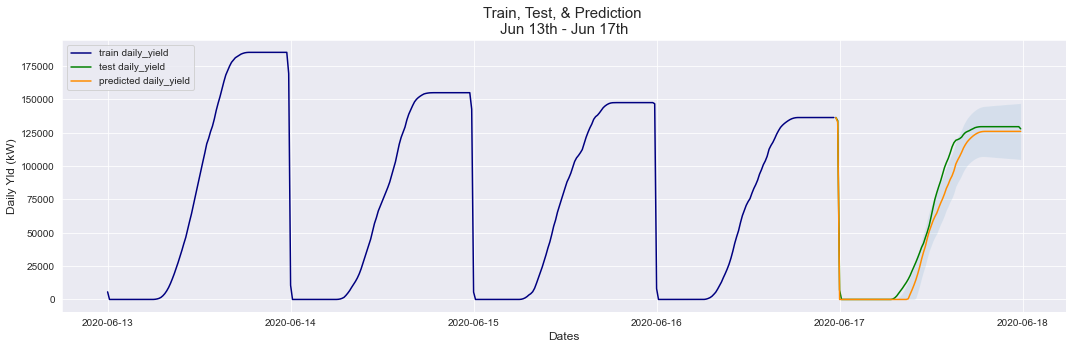

In [215]:
fig,ax = plt.subplots(figsize = (18,5))

ax.plot(train.DAILY_YIELD, label = 'train daily_yield', color = 'navy')
ax.plot(test.DAILY_YIELD, label = 'test daily_yield', color = 'green')
ax.plot(prediction_df.pred_daily_yld, label = 'predicted daily_yield', color = 'darkorange')
ax.fill_between(prediction_df.index, prediction_df.conf_lower, prediction_df.conf_upper, alpha=0.1)
ax.legend(loc = 'upper left')
ax.set_title('Train, Test, & Prediction \n Jun 13th - Jun 17th ', size=15)
ax.set_ylabel('Daily Yld (kW)', size=12)
ax.set_xlabel('Dates', size=12)
plt.show()

In [190]:
print(arima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  382
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 96)   Log Likelihood               -2385.366
Date:                              Fri, 20 Nov 2020   AIC                           4778.731
Time:                                      14:06:05   BIC                           4793.341
Sample:                                           0   HQIC                          4784.588
                                              - 382                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0631      0.010      6.403      0.000       0.044       0.082
ar.S.L96      -0.04

In [196]:
print('SARIMA R2 Score: %f' % (r2_score(prediction_df['actual_daily_yld'],
                                        prediction_df['pred_daily_yld'])))
print('-'*15)

print('SARIMA MAE Score: %f' % (mean_absolute_error(prediction_df['actual_daily_yld'],
                                        prediction_df['pred_daily_yld'])))
print('-'*15)

print('SARIMA RMSE Score: %f' % (mean_squared_error(prediction_df['actual_daily_yld'],
                                                    prediction_df['pred_daily_yld']
                                                    ,squared=False)))

SARIMA R2 Score: 0.976500
---------------
SARIMA MAE Score: 6148.568241
---------------
SARIMA RMSE Score: 8743.150754


## Forecasting 
2 days ahead

In [130]:
# doing calculations for how many 'n's we need (n = periods). 
# We're going to use 2 more n's than what we have here to complete 2 days forward

print(24*60, 24*60*2, 24*60/15, 24*60/15*2)

1440 2880 96.0 192.0


In [114]:
# make a list of future dates with time stamps, to use as index when forecasting below

future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15)]
# 2880 doesn't go all the way to the end of 2 days, bc we're starting earlier
# so use 2910

In [63]:
print(len(future_dates))
future_dates

194


[Timestamp('2020-06-17 23:45:00'),
 Timestamp('2020-06-18 00:00:00'),
 Timestamp('2020-06-18 00:15:00'),
 Timestamp('2020-06-18 00:30:00'),
 Timestamp('2020-06-18 00:45:00'),
 Timestamp('2020-06-18 01:00:00'),
 Timestamp('2020-06-18 01:15:00'),
 Timestamp('2020-06-18 01:30:00'),
 Timestamp('2020-06-18 01:45:00'),
 Timestamp('2020-06-18 02:00:00'),
 Timestamp('2020-06-18 02:15:00'),
 Timestamp('2020-06-18 02:30:00'),
 Timestamp('2020-06-18 02:45:00'),
 Timestamp('2020-06-18 03:00:00'),
 Timestamp('2020-06-18 03:15:00'),
 Timestamp('2020-06-18 03:30:00'),
 Timestamp('2020-06-18 03:45:00'),
 Timestamp('2020-06-18 04:00:00'),
 Timestamp('2020-06-18 04:15:00'),
 Timestamp('2020-06-18 04:30:00'),
 Timestamp('2020-06-18 04:45:00'),
 Timestamp('2020-06-18 05:00:00'),
 Timestamp('2020-06-18 05:15:00'),
 Timestamp('2020-06-18 05:30:00'),
 Timestamp('2020-06-18 05:45:00'),
 Timestamp('2020-06-18 06:00:00'),
 Timestamp('2020-06-18 06:15:00'),
 Timestamp('2020-06-18 06:30:00'),
 Timestamp('2020-06-

In [197]:
f_prediction = arima_model.predict(n_periods=194,return_conf_int=True)

In [198]:
# I need to convert prediction into a dataframe with cols: pred_daily_yld, conf_lower, conf_upper

f_prediction_yhat_df = pd.DataFrame(f_prediction[0],index=future_dates,columns=['forecast_daily_yld'])
f_prediction_yhat_df

f_prediction_conf_df = pd.DataFrame(f_prediction[1], 
                                  index=future_dates, 
                                  columns=['conf_lower', 'conf_upper'])

# join the two 
f_prediction_df = f_prediction_yhat_df.join(f_prediction_conf_df)

# zero out neg values in pred_daily_yld col only
# prediction_df['pred_daily_yld'][prediction_df.pred_daily_yld < 0] = 0
f_prediction_df[f_prediction_df < 0] = 0
f_prediction_df

,forecast_daily_yld,conf_lower,conf_upper
2020-06-17 23:45:00,136431.015771,134413.930005,138448.101538
2020-06-18 00:00:00,133115.002534,130171.047899,136058.957169
2020-06-18 00:15:00,0.000000,0.000000,0.000000
2020-06-18 00:30:00,0.000000,0.000000,0.000000
2020-06-18 00:45:00,0.000000,0.000000,0.000000
...,...,...,...
2020-06-19 23:00:00,115607.145882,72715.080647,158499.211118
2020-06-19 23:15:00,115607.146264,72542.277193,158672.015335
2020-06-19 23:30:00,115607.157073,72370.174815,158844.139330
2020-06-19 23:45:00,115609.093933,72028.061545,159190.126321


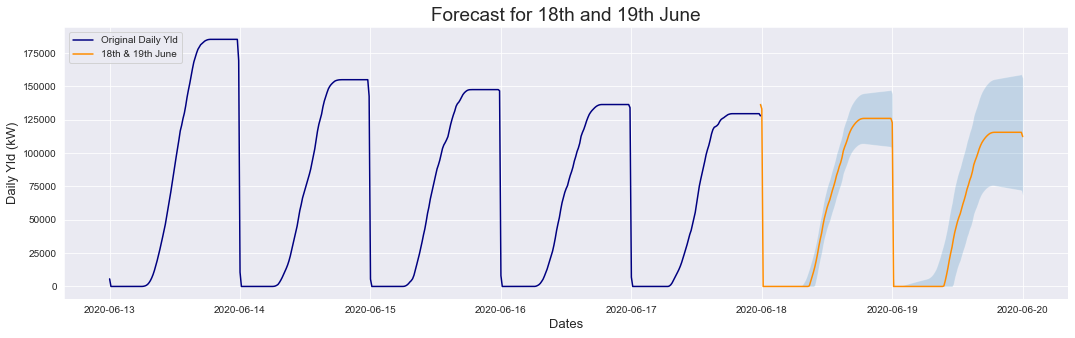

In [212]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(pred_gen.DAILY_YIELD, label = 'Original Daily Yld', color = 'navy')
ax.plot(f_prediction_df.forecast_daily_yld, label='18th & 19th June', color = 'darkorange')
ax.fill_between(f_prediction_df.index, f_prediction_df.conf_lower, f_prediction_df.conf_upper, alpha=0.2)
ax.legend(loc='upper left')
ax.set_title('Forecast for 18th and 19th June', size=19)
ax.set_ylabel('Daily Yld (kW)', size=13)
ax.set_xlabel('Dates', size=13)
plt.show()

---

# SARIMA Model (using Max's function to determine order)

Above I used auto_arima as my model, both for my prediction and forecasting...

In project 4, I used auto_arima separately, then ARIMA model to predict, and SARIMAX model to forecast.

So, I'm going to try SARIMAX here real quick, bc I want to get the confidence level

I'm going to train/test first to get some metrics, and then forecast

In [122]:
train

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-16 22:15:00,136429.000000
2020-06-16 22:30:00,136429.000000
2020-06-16 22:45:00,136429.000000


In [123]:
test

,DAILY_YIELD
DATE_TIME,
2020-06-16 23:30:00,136429.000000
2020-06-16 23:45:00,134079.375000
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


## USING AUTO_ARIMA ORDER FROM ABOVE

In [ ]:
(train,
                         start_p=0,d=i,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

In [ ]:
sarima_model = SARIMAX(train, )

## RUNNING CODE FROM PROJECT 4 (to get order)

Below: Emulating the workflow from project 4 SARIMAX

In [125]:
import itertools

i = dicky_fuller(df_zip_code_train)

p = q = range(0, 3)
pdq = list(itertools.product(p, [i], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 2, 0) x (0, 1, 0, 12)
SARIMAX: (0, 2, 0) x (0, 1, 1, 12)
SARIMAX: (0, 2, 0) x (0, 1, 2, 12)
SARIMAX: (0, 2, 0) x (1, 1, 0, 12)
SARIMAX: (0, 2, 0) x (1, 1, 1, 12)
SARIMAX: (0, 2, 0) x (1, 1, 2, 12)
SARIMAX: (0, 2, 0) x (2, 1, 0, 12)
SARIMAX: (0, 2, 0) x (2, 1, 1, 12)
SARIMAX: (0, 2, 0) x (2, 1, 2, 12)
SARIMAX: (0, 2, 1) x (0, 1, 0, 12)
SARIMAX: (0, 2, 1) x (0, 1, 1, 12)
SARIMAX: (0, 2, 1) x (0, 1, 2, 12)
SARIMAX: (0, 2, 1) x (1, 1, 0, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
SARIMAX: (0, 2, 1) x (1, 1, 2, 12)
SARIMAX: (0, 2, 1) x (2, 1, 0, 12)
SARIMAX: (0, 2, 1) x (2, 1, 1, 12)
SARIMAX: (0, 2, 1) x (2, 1, 2, 12)
SARIMAX: (0, 2, 2) x (0, 1, 0, 12)
SARIMAX: (0, 2, 2) x (0, 1, 1, 12)
SARIMAX: (0, 2, 2) x (0, 1, 2, 12)
SARIMAX: (0, 2, 2) x (1, 1, 0, 12)
SARIMAX: (0, 2, 2) x (1, 1, 1, 12)
SARIMAX: (0, 2, 2) x (1, 1, 2, 12)
SARIMAX: (0, 2, 2) x (2, 1, 0, 12)
SARIMAX: (0, 2, 2) x (2, 1, 1, 12)
SARIMAX: (0, 2, 2) x (2, 1, 2, 12)
SARIMAX: (1, 2, 0) 

In [126]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(df_zip_code_train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False, 
                         freq='MS')
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:739.507127257072


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:921.5640974953036
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:348.5377340585172
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:538.1015920183934


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(1, 1, 1, 12) - AIC:1574.995979790494
ARIMA(0, 2, 0)x(1, 1, 2, 12) - AIC:347.1913111955339
ARIMA(0, 2, 0)x(2, 1, 0, 12) - AIC:359.71708511187205


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 1, 12) - AIC:604.1074280396389


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 2, 12) - AIC:349.04431705054054
ARIMA(0, 2, 1)x(0, 1, 0, 12) - AIC:707.0846958853389


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(0, 1, 1, 12) - AIC:523.4583313396505
ARIMA(0, 2, 1)x(0, 1, 2, 12) - AIC:324.30090870138895
ARIMA(0, 2, 1)x(1, 1, 0, 12) - AIC:539.7958617012677


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(1, 1, 1, 12) - AIC:1162.9212110702067
ARIMA(0, 2, 1)x(1, 1, 2, 12) - AIC:325.06968966207324


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 0, 12) - AIC:361.7105022887313


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 1, 12) - AIC:575.2383177183277
ARIMA(0, 2, 1)x(2, 1, 2, 12) - AIC:329.22271246909776
ARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:680.3676100851715


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:2018.9644419026026


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:301.24129351440416


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 0, 12) - AIC:539.4428566274089


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 1, 12) - AIC:nan


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 2, 12) - AIC:307.4100710773852
ARIMA(0, 2, 2)x(2, 1, 0, 12) - AIC:358.4828267791329


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 1, 12) - AIC:nan


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 2, 12) - AIC:311.74387990944433
ARIMA(1, 2, 0)x(0, 1, 0, 12) - AIC:738.8577429258805


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(0, 1, 1, 12) - AIC:838.4444439089245
ARIMA(1, 2, 0)x(0, 1, 2, 12) - AIC:346.0959172589715
ARIMA(1, 2, 0)x(1, 1, 0, 12) - AIC:520.1690870527591


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 1, 12) - AIC:1661.799406916834
ARIMA(1, 2, 0)x(1, 1, 2, 12) - AIC:345.0793670559997


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 0, 12) - AIC:342.9475688595281


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 1, 12) - AIC:988.2906255885656


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 2, 12) - AIC:347.11973889454936
ARIMA(1, 2, 1)x(0, 1, 0, 12) - AIC:709.1538483819398


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(0, 1, 1, 12) - AIC:1235.6650634964042
ARIMA(1, 2, 1)x(0, 1, 2, 12) - AIC:326.2768482625869
ARIMA(1, 2, 1)x(1, 1, 0, 12) - AIC:521.524833041476


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:1413.3268816101788
ARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:326.26039486235413


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 0, 12) - AIC:342.942326405817


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 1, 12) - AIC:708.0317725452902


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 2, 12) - AIC:330.9271884443519
ARIMA(1, 2, 2)x(0, 1, 0, 12) - AIC:683.0841471651444


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:1244.0845346823585
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:310.75206935993884


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:521.2969434628892


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:1063.8766274902962
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:312.3099409110797


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:341.44553765405743


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:1011.1954754258315
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:312.63227532815944
ARIMA(2, 2, 0)x(0, 1, 0, 12) - AIC:696.8318080430075


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(0, 1, 1, 12) - AIC:671.7765448371955
ARIMA(2, 2, 0)x(0, 1, 2, 12) - AIC:333.9753643834554


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 0, 12) - AIC:490.35052113818693


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 1, 12) - AIC:963.0383463693454
ARIMA(2, 2, 0)x(1, 1, 2, 12) - AIC:334.9071467192183


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 0, 12) - AIC:313.4529344695118


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 1, 12) - AIC:443.47015234790257
ARIMA(2, 2, 0)x(2, 1, 2, 12) - AIC:317.35704791510966
ARIMA(2, 2, 1)x(0, 1, 0, 12) - AIC:698.5269874194867


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(0, 1, 1, 12) - AIC:1587.43583994057
ARIMA(2, 2, 1)x(0, 1, 2, 12) - AIC:319.7423359914868


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 0, 12) - AIC:492.0538788068469


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 1, 12) - AIC:1649.2275201537475
ARIMA(2, 2, 1)x(1, 1, 2, 12) - AIC:320.56006111987216


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 0, 12) - AIC:315.17596359897686


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 1, 12) - AIC:910.8085748432043
ARIMA(2, 2, 1)x(2, 1, 2, 12) - AIC:322.5482304581907
ARIMA(2, 2, 2)x(0, 1, 0, 12) - AIC:674.5812861041143


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 1, 12) - AIC:1586.1973093281947


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:300.98116449958405
ARIMA(2, 2, 2)x(1, 1, 0, 12) - AIC:493.0033525209441


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 1, 12) - AIC:1573.4317684201537


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 2, 12) - AIC:305.2459447596299
ARIMA(2, 2, 2)x(2, 1, 0, 12) - AIC:317.17130228202575


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(2, 1, 1, 12) - AIC:501.96376651614804
ARIMA(2, 2, 2)x(2, 1, 2, 12) - AIC:304.9152275566815


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
